# Méthode semi-Lagrangienne généralisée

Cette méthode ne fait pas d'interpolation à chaque itération en temps, mais revient à la condition initiale sur la 
grille grâce aux caractéristiques.

Une amélioration possible est de procéder à une interpolation tous les $T$ itérations afin de ne pas avoir de soucis
dans la quadrature lorsque les caractéristiques tendent à converger vers une zone restreinte du domaine d'étude.

In [1]:
using LinearAlgebra, QuadGK, Roots, FFTW
using VlasovSolvers
using Plots

import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PIC_step!, compute_rho
using ProgressMeter

using LaTeXStrings

In [2]:
function generalized_SL(nsteps::Int64, meshx::OneDGrid, meshv::OneDGrid, f0::Function; plotting=false::Bool)

    x0 = Array(meshx.points)
    v0 = Array(meshv.points)

    newX = repeat(x0, 1, nv)   # newX[i, j] is position at current time when starting from x0_i, v0_j
    newV = repeat(v0', nx, 1)  # newV[i, j] is velocity at current time when starting from x0_i, v0_j

    E2_elec  = Array{Float64}(undef, nstep)
    E_tot   = Array{Float64}(undef, nstep)
    dphidx  = similar(newX)
    arr_C   = Array{Float64}(undef, nstep)
    arr_S   = Array{Float64}(undef, nstep)
        
    progression = ProgressMeter.Progress(nstep,desc="Loop in time: ", showspeed=true)
    
    f0vals = f0.(x0, v0')
    
    newX .+= dt/2 .* newV
    
    @time animation = @animate for istep=1:nstep
        C = sum(cos.(newX.*kx) .* f0vals) .* meshx.step .* meshv.step
        S = sum(sin.(newX.*kx) .* f0vals) .* meshx.step .* meshv.step
        arr_C[istep] = C
        arr_S[istep] = S
    
        dphidx   .= (-C.*sin.(newX .* kx) .+ S.*cos.(newX .* kx)) / π
        E2_elec[istep] = (C^2 + S^2) / (kx*π)
        E_tot[istep] = sqrt(E2_elec[istep] + sum(newV.^2 .* f0vals) * meshx.step * meshv.step) / √2 
        
        newV    .-= dt .* dphidx
        newX    .+= dt .* newV
    
        newX[findall(newX .> meshx.stop)] .-= meshx.stop - meshx.start
        newX[findall(newX .< meshx.start )] .+= meshx.stop - meshx.start
 
        if plotting
            p1 = plot(x0, v0, f.(newX, newV)', size=(500, 500), st=:surface, camera=(0, 90), widen=false)
            p2 = histogram2d(vec(newX), vec(newV), bins=250, normalize=true, xlabel="position", ylabel="velocity", fillcolor=:roma)
            plot(p1, p2)
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        ProgressMeter.next!(progression)
     end when plotting

     return sqrt.(E2_elec), E_tot, animation
end

generalized_SL (generic function with 1 method)

# INPUTS

## Landau damping

In [93]:
kx = 0.4
L = 2π / kx
ϵ = 0.001
μ = 0.0
β = 1.0
f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * (v-μ)^2 / 2) / √(2π/β)
castest = "Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

"Landau damping\n(kx, ϵ, μ, β) = (0.4, 0.001, 0.0, 1.0))"

## Two-Stream Instability

In [45]:
kx = 0.2
L = 2π / kx
ϵ = 0.001
β₁ = 1
β₂ = 1
v0 = 3.0
μ₁ =  v0
μ₂ = -v0
@. f(x,v) = (1 + ϵ * cos(kx * x)) * (exp(-β₁*(v-μ₁)^2 / 2) + exp(-β₁*(v-μ₂)^2 / 2)) / (√(2π)) * 0.5
castest = "TSI\n(kx, β₁, β₂, μ₁, μ₂) = $((kx, β₁, β₂, μ₁, μ₂))"

"TSI\n(kx, β₁, β₂, μ₁, μ₂) = (0.2, 1, 1, 3.0, -3.0)"

## Bump-on-Tail

In [66]:
kx = 0.3
L = 3*2π / kx
ϵ = 0.04
β₁ = 1
β₂ = 1 / (0.5^2)
μ₁ = 0
μ₂ = 4.5
nb = 0.2
np = 0.9
@. f(x,v) = (1 + ϵ * cos(kx*x)) * (np*exp(-β₁*(v-μ₁)^2 /2) + nb*exp(-β₂*(v-μ₂)^2 / 2)) / √(2π)
castest = "Bump on tail\n(kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np) = $((kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np))"

"Bump on tail\n(kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np) = (0.3, 0.04, 1, 4.0, 0, 4.5, 0.2, 0.9)"

## Strong Landau Damping

In [75]:
kx = 0.5
L = 2π / kx
ϵ = 0.5
β = 1.0
μ = 0.0
@. f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * v^2 / 2) / √(2π/β)
castest = "Strong Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

"Strong Landau damping\n(kx, ϵ, μ, β) = (0.5, 0.5, 0.0, 1.0))"

# Inputs indépendants du cas test

In [94]:
dev = CPU()

nstep = 10000
dt = 0.01

0.01

# Méthode SL généralisée

In [95]:
nx = 128
nv = 127

127

In [96]:
meshx = OneDGrid(dev, nx, 0, L)
meshv = OneDGrid(dev, nv, -10, 10)

OneDGrid(CPU(), 127, -10, 10, range(-10.0, stop=9.84251968503937, length=127), 0.15748031496062992)

In [97]:
p = false
E_elec, E_tot, animation = generalized_SL(nstep, meshx, meshv, f, plotting=p);

Loop in time: 100%|███████████████████████| Time: 0:00:08 ( 0.90 ms/it)


  8.866169 seconds (1.03 M allocations: 6.216 GiB, 6.62% gc time)


In [98]:
if p
    gif(animation, "semilag_caracteristiques.gif")
end

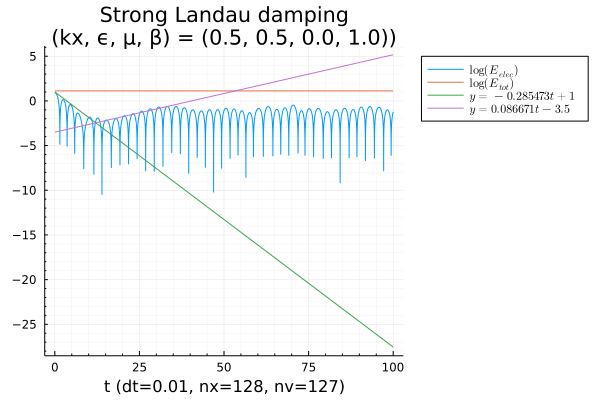

In [91]:
t = (1:nstep).*dt

# energies
# plot(t, E_elec.^2, label=L"E_{elec}^2", legend=:outertopright, minorgrid=true)
# plot!(t, E_tot, label=L"E_{tot}", scaley=:log10)

# log(Energies)
plot(t, log.(E_elec), label=L"\log(E_{elec})", legend=:outertopright, minorgrid=true)
# plot(t, E_elec.^2)
plot!(t, log.(E_tot), label=L"\log(E_{tot})")

# ============== #

# Landau damping (kx=0.5):
# plot!(x->-0.1533x - 5.6, label="Damping attendu")
# Landau damping (kx=0.4):
# plot!(x->-0.0661x - 5.3, label="Damping attendu")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
E_th = abs.(4*ϵ*0.424666*exp.(-0.0661 .* t) .* sqrt(π/kx) .* cos.(1.2850 .* t .- 0.3357725)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
plot!(t, log.(E_th),label="Energie theorique", ls=:dash)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, -0.001t .- 4.2, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 6.4, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 6.1, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .+ 1, label=L"y=-0.285473t + 1")
# plot!(t, 0.086671t .- 3.5, label=L"y=0.086671t - 3.5")

title!(castest)
xlabel!("t (dt=$(dt), nx=$(nx), nv=$(nv))")

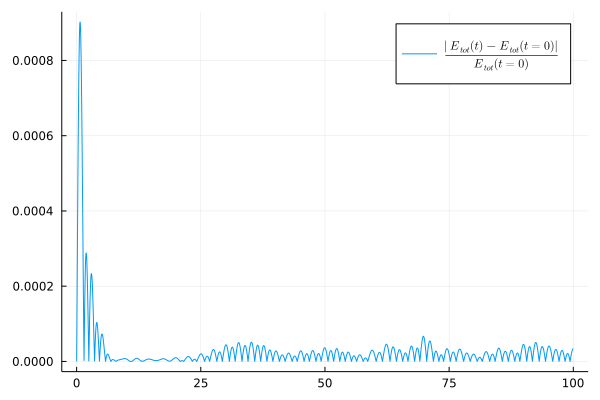

In [82]:
plot(t, abs.((E_tot .- E_tot[1])) ./ E_tot[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}")

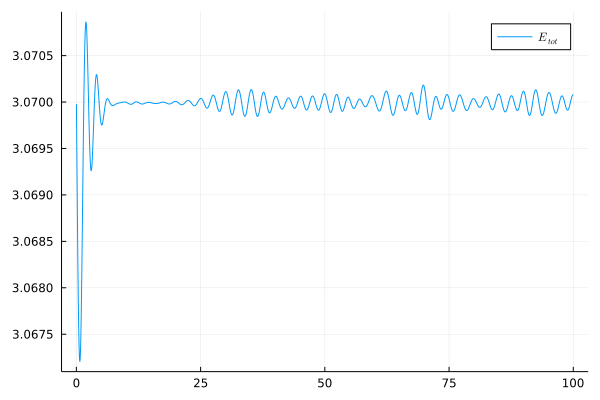

In [83]:
plot(t, E_tot, label=L"E_{tot}")